In [1]:
import cv2
import audioread
import logging
import os
import random
import time
import warnings

import librosa
import librosa.display as display
import numpy as np
import pandas as pd
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

from contextlib import contextmanager
from IPython.display import Audio
from pathlib import Path
from typing import Optional, List

from catalyst.dl import SupervisedRunner, State, CallbackOrder, Callback, CheckpointCallback
from fastprogress import progress_bar
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, average_precision_score

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
    
    
def get_logger(out_file=None):
    logger = logging.getLogger()
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    logger.handlers = []
    logger.setLevel(logging.INFO)

    handler = logging.StreamHandler()
    handler.setFormatter(formatter)
    handler.setLevel(logging.INFO)
    logger.addHandler(handler)

    if out_file is not None:
        fh = logging.FileHandler(out_file)
        fh.setFormatter(formatter)
        fh.setLevel(logging.INFO)
        logger.addHandler(fh)
    logger.info("logger set up")
    return logger
    
    
@contextmanager
def timer(name: str, logger: Optional[logging.Logger] = None):
    t0 = time.time()
    msg = f"[{name}] start"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)
    yield

    msg = f"[{name}] done in {time.time() - t0:.2f} s"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)
    
    
set_seed(1213)

In [3]:
ROOT = Path.cwd().parent
INPUT_ROOT = ROOT / "input"
RAW_DATA = INPUT_ROOT / "birdsong-recognition"
TRAIN_AUDIO_DIR = RAW_DATA / "train_audio"
TRAIN_RESAMPLED_AUDIO_DIRS = [
  INPUT_ROOT / "birdsong-resampled-train-audio-{:0>2}".format(i)  for i in range(5)
]
TEST_AUDIO_DIR = RAW_DATA / "test_audio"

In [4]:
train = pd.read_csv(TRAIN_RESAMPLED_AUDIO_DIRS[0] / "train_mod.csv")

if not TEST_AUDIO_DIR.exists():
    TEST_AUDIO_DIR = INPUT_ROOT / "birdcall-check" / "test_audio"
    test = pd.read_csv(INPUT_ROOT / "birdcall-check" / "test.csv")
else:
    test = pd.read_csv(RAW_DATA / "test.csv")

### torchlibrosa


In PANNs, `torchlibrosa`, a PyTorch based implementation are used to replace some of the `librosa`'s functions. Here I use some functions of `torchlibrosa`.

Ref: https://github.com/qiuqiangkong/torchlibrosa

#### LICENSE

```
ISC License
Copyright (c) 2013--2017, librosa development team.

Permission to use, copy, modify, and/or distribute this software for any purpose with or without fee is hereby granted, provided that the above copyright notice and this permission notice appear in all copies.

THE SOFTWARE IS PROVIDED "AS IS" AND THE AUTHOR DISCLAIMS ALL WARRANTIES WITH REGARD TO THIS SOFTWARE INCLUDING ALL IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR ANY SPECIAL, DIRECT, INDIRECT, OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, WHETHER IN AN ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION, ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF THIS SOFTWARE.
```

In [5]:
class DFTBase(nn.Module):
    def __init__(self):
        """Base class for DFT and IDFT matrix"""
        super(DFTBase, self).__init__()

    def dft_matrix(self, n):
        (x, y) = np.meshgrid(np.arange(n), np.arange(n))
        omega = np.exp(-2 * np.pi * 1j / n)
        W = np.power(omega, x * y)
        return W

    def idft_matrix(self, n):
        (x, y) = np.meshgrid(np.arange(n), np.arange(n))
        omega = np.exp(2 * np.pi * 1j / n)
        W = np.power(omega, x * y)
        return W
    
    
class STFT(DFTBase):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None, 
        window='hann', center=True, pad_mode='reflect', freeze_parameters=True):
        """Implementation of STFT with Conv1d. The function has the same output 
        of librosa.core.stft
        """
        super(STFT, self).__init__()

        assert pad_mode in ['constant', 'reflect']

        self.n_fft = n_fft
        self.center = center
        self.pad_mode = pad_mode

        # By default, use the entire frame
        if win_length is None:
            win_length = n_fft

        # Set the default hop, if it's not already specified
        if hop_length is None:
            hop_length = int(win_length // 4)

        fft_window = librosa.filters.get_window(window, win_length, fftbins=True)

        # Pad the window out to n_fft size
        fft_window = librosa.util.pad_center(fft_window, n_fft)

        # DFT & IDFT matrix
        self.W = self.dft_matrix(n_fft)

        out_channels = n_fft // 2 + 1

        self.conv_real = nn.Conv1d(in_channels=1, out_channels=out_channels, 
            kernel_size=n_fft, stride=hop_length, padding=0, dilation=1, 
            groups=1, bias=False)

        self.conv_imag = nn.Conv1d(in_channels=1, out_channels=out_channels, 
            kernel_size=n_fft, stride=hop_length, padding=0, dilation=1, 
            groups=1, bias=False)

        self.conv_real.weight.data = torch.Tensor(
            np.real(self.W[:, 0 : out_channels] * fft_window[:, None]).T)[:, None, :]
        # (n_fft // 2 + 1, 1, n_fft)

        self.conv_imag.weight.data = torch.Tensor(
            np.imag(self.W[:, 0 : out_channels] * fft_window[:, None]).T)[:, None, :]
        # (n_fft // 2 + 1, 1, n_fft)

        if freeze_parameters:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, input):
        """input: (batch_size, data_length)
        Returns:
          real: (batch_size, n_fft // 2 + 1, time_steps)
          imag: (batch_size, n_fft // 2 + 1, time_steps)
        """

        x = input[:, None, :]   # (batch_size, channels_num, data_length)

        if self.center:
            x = F.pad(x, pad=(self.n_fft // 2, self.n_fft // 2), mode=self.pad_mode)

        real = self.conv_real(x)
        imag = self.conv_imag(x)
        # (batch_size, n_fft // 2 + 1, time_steps)

        real = real[:, None, :, :].transpose(2, 3)
        imag = imag[:, None, :, :].transpose(2, 3)
        # (batch_size, 1, time_steps, n_fft // 2 + 1)

        return real, imag
    
    
class Spectrogram(nn.Module):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None, 
        window='hann', center=True, pad_mode='reflect', power=2.0, 
        freeze_parameters=True):
        """Calculate spectrogram using pytorch. The STFT is implemented with 
        Conv1d. The function has the same output of librosa.core.stft
        """
        super(Spectrogram, self).__init__()

        self.power = power

        self.stft = STFT(n_fft=n_fft, hop_length=hop_length, 
            win_length=win_length, window=window, center=center, 
            pad_mode=pad_mode, freeze_parameters=True)

    def forward(self, input):
        """input: (batch_size, 1, time_steps, n_fft // 2 + 1)
        Returns:
          spectrogram: (batch_size, 1, time_steps, n_fft // 2 + 1)
        """

        (real, imag) = self.stft.forward(input)
        # (batch_size, n_fft // 2 + 1, time_steps)

        spectrogram = real ** 2 + imag ** 2

        if self.power == 2.0:
            pass
        else:
            spectrogram = spectrogram ** (power / 2.0)

        return spectrogram

    
class LogmelFilterBank(nn.Module):
    def __init__(self, sr=32000, n_fft=2048, n_mels=64, fmin=50, fmax=14000, is_log=True, 
        ref=1.0, amin=1e-10, top_db=80.0, freeze_parameters=True):
        """Calculate logmel spectrogram using pytorch. The mel filter bank is 
        the pytorch implementation of as librosa.filters.mel 
        """
        super(LogmelFilterBank, self).__init__()

        self.is_log = is_log
        self.ref = ref
        self.amin = amin
        self.top_db = top_db

        self.melW = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels,
            fmin=fmin, fmax=fmax).T
        # (n_fft // 2 + 1, mel_bins)

        self.melW = nn.Parameter(torch.Tensor(self.melW))

        if freeze_parameters:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, input):
        """input: (batch_size, channels, time_steps)
        
        Output: (batch_size, time_steps, mel_bins)
        """

        # Mel spectrogram
        mel_spectrogram = torch.matmul(input, self.melW)

        # Logmel spectrogram
        if self.is_log:
            output = self.power_to_db(mel_spectrogram)
        else:
            output = mel_spectrogram

        return output


    def power_to_db(self, input):
        """Power to db, this function is the pytorch implementation of 
        librosa.core.power_to_lb
        """
        ref_value = self.ref
        log_spec = 10.0 * torch.log10(torch.clamp(input, min=self.amin, max=np.inf))
        log_spec -= 10.0 * np.log10(np.maximum(self.amin, ref_value))

        if self.top_db is not None:
            if self.top_db < 0:
                raise ParameterError('top_db must be non-negative')
            log_spec = torch.clamp(log_spec, min=log_spec.max().item() - self.top_db, max=np.inf)

        return log_spec

In [6]:
class DropStripes(nn.Module):
    def __init__(self, dim, drop_width, stripes_num):
        """Drop stripes. 
        Args:
          dim: int, dimension along which to drop
          drop_width: int, maximum width of stripes to drop
          stripes_num: int, how many stripes to drop
        """
        super(DropStripes, self).__init__()

        assert dim in [2, 3]    # dim 2: time; dim 3: frequency

        self.dim = dim
        self.drop_width = drop_width
        self.stripes_num = stripes_num

    def forward(self, input):
        """input: (batch_size, channels, time_steps, freq_bins)"""

        assert input.ndimension() == 4

        if self.training is False:
            return input

        else:
            batch_size = input.shape[0]
            total_width = input.shape[self.dim]

            for n in range(batch_size):
                self.transform_slice(input[n], total_width)

            return input


    def transform_slice(self, e, total_width):
        """e: (channels, time_steps, freq_bins)"""

        for _ in range(self.stripes_num):
            distance = torch.randint(low=0, high=self.drop_width, size=(1,))[0]
            bgn = torch.randint(low=0, high=total_width - distance, size=(1,))[0]

            if self.dim == 2:
                e[:, bgn : bgn + distance, :] = 0
            elif self.dim == 3:
                e[:, :, bgn : bgn + distance] = 0


class SpecAugmentation(nn.Module):
    def __init__(self, time_drop_width, time_stripes_num, freq_drop_width, 
        freq_stripes_num):
        """Spec augmetation. 
        [ref] Park, D.S., Chan, W., Zhang, Y., Chiu, C.C., Zoph, B., Cubuk, E.D. 
        and Le, Q.V., 2019. Specaugment: A simple data augmentation method 
        for automatic speech recognition. arXiv preprint arXiv:1904.08779.
        Args:
          time_drop_width: int
          time_stripes_num: int
          freq_drop_width: int
          freq_stripes_num: int
        """

        super(SpecAugmentation, self).__init__()

        self.time_dropper = DropStripes(dim=2, drop_width=time_drop_width, 
            stripes_num=time_stripes_num)

        self.freq_dropper = DropStripes(dim=3, drop_width=freq_drop_width, 
            stripes_num=freq_stripes_num)

    def forward(self, input):
        x = self.time_dropper(input)
        x = self.freq_dropper(x)
        return x

### audioset_tagging_cnn

I also use `Cnn14_DecisionLevelAtt` model from [PANNs models](https://github.com/qiuqiangkong/audioset_tagging_cnn/blob/master/pytorch/models.py), which is a SED model.

#### LICENSE

```
The MIT License
  
Copyright (c) 2010-2017 Google, Inc. http://angularjs.org

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.
```

### Building blocks

In [7]:
def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)


def init_bn(bn):
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.0)


def interpolate(x: torch.Tensor, ratio: int):
    """Interpolate data in time domain. This is used to compensate the
    resolution reduction in downsampling of a CNN.

    Args:
      x: (batch_size, time_steps, classes_num)
      ratio: int, ratio to interpolate
    Returns:
      upsampled: (batch_size, time_steps * ratio, classes_num)
    """
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    return upsampled


def pad_framewise_output(framewise_output: torch.Tensor, frames_num: int):
    """Pad framewise_output to the same length as input frames. The pad value
    is the same as the value of the last frame.
    Args:
      framewise_output: (batch_size, frames_num, classes_num)
      frames_num: int, number of frames to pad
    Outputs:
      output: (batch_size, frames_num, classes_num)
    """
    pad = framewise_output[:, -1:, :].repeat(
        1, frames_num - framewise_output.shape[1], 1)
    """tensor for padding"""

    output = torch.cat((framewise_output, pad), dim=1)
    """(batch_size, frames_num, classes_num)"""

    return output


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False)

        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False)

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.init_weight()

    def init_weight(self):
        init_layer(self.conv1)
        init_layer(self.conv2)
        init_bn(self.bn1)
        init_bn(self.bn2)

    def forward(self, input, pool_size=(2, 2), pool_type='avg'):

        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        x = F.relu_(self.bn2(self.conv2(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            raise Exception('Incorrect argument!')

        return x


class AttBlock(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear",
                 temperature=1.0):
        super().__init__()

        self.activation = activation
        self.temperature = temperature
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.bn_att = nn.BatchNorm1d(out_features)
        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)
        init_bn(self.bn_att)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.clamp(self.att(x), -10, 10), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)

In [8]:
class PANNsCNN14Att(nn.Module):
    def __init__(self, sample_rate: int, window_size: int, hop_size: int,
                 mel_bins: int, fmin: int, fmax: int, classes_num: int):
        super().__init__()

        window = 'hann'
        center = True
        pad_mode = 'reflect'
        ref = 1.0
        amin = 1e-10
        top_db = None
        self.interpolate_ratio = 32  # Downsampled ratio

        # Spectrogram extractor
        self.spectrogram_extractor = Spectrogram(
            n_fft=window_size,
            hop_length=hop_size,
            win_length=window_size,
            window=window,
            center=center,
            pad_mode=pad_mode,
            freeze_parameters=True)

        # Logmel feature extractor
        self.logmel_extractor = LogmelFilterBank(
            sr=sample_rate,
            n_fft=window_size,
            n_mels=mel_bins,
            fmin=fmin,
            fmax=fmax,
            ref=ref,
            amin=amin,
            top_db=top_db,
            freeze_parameters=True)

        # Spec augmenter
        self.spec_augmenter = SpecAugmentation(
            time_drop_width=64,
            time_stripes_num=2,
            freq_drop_width=8,
            freq_stripes_num=2)

        self.bn0 = nn.BatchNorm2d(mel_bins)

        self.conv_block1 = ConvBlock(in_channels=1, out_channels=64)
        self.conv_block2 = ConvBlock(in_channels=64, out_channels=128)
        self.conv_block3 = ConvBlock(in_channels=128, out_channels=256)
        self.conv_block4 = ConvBlock(in_channels=256, out_channels=512)
        self.conv_block5 = ConvBlock(in_channels=512, out_channels=1024)
        self.conv_block6 = ConvBlock(in_channels=1024, out_channels=2048)

        self.fc1 = nn.Linear(2048, 2048, bias=True)
        self.att_block = AttBlock(2048, classes_num, activation='sigmoid')

        self.init_weight()

    def init_weight(self):
        init_bn(self.bn0)
        init_layer(self.fc1)
        
    def cnn_feature_extractor(self, x):
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block4(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block5(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block6(x, pool_size=(1, 1), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        return x
    
    def preprocess(self, input, mixup_lambda=None):
        # t1 = time.time()
        x = self.spectrogram_extractor(input)  # (batch_size, 1, time_steps, freq_bins)
        x = self.logmel_extractor(x)  # (batch_size, 1, time_steps, mel_bins)

        frames_num = x.shape[2]

        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)

        if self.training:
            x = self.spec_augmenter(x)

        # Mixup on spectrogram
        if self.training and mixup_lambda is not None:
            x = do_mixup(x, mixup_lambda)
        return x, frames_num
        

    def forward(self, input, mixup_lambda=None):
        """
        Input: (batch_size, data_length)"""
        x, frames_num = self.preprocess(input, mixup_lambda=mixup_lambda)

        # Output shape (batch size, channels, time, frequency)
        x = self.cnn_feature_extractor(x)
        
        # Aggregate in frequency axis
        x = torch.mean(x, dim=3)

        x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2

        x = F.dropout(x, p=0.5, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)
        x = F.dropout(x, p=0.5, training=self.training)

        (clipwise_output, norm_att, segmentwise_output) = self.att_block(x)
        segmentwise_output = segmentwise_output.transpose(1, 2)

        # Get framewise output
        framewise_output = interpolate(segmentwise_output,
                                       self.interpolate_ratio)
        framewise_output = pad_framewise_output(framewise_output, frames_num)

        output_dict = {
            'framewise_output': framewise_output,
            'clipwise_output': clipwise_output
        }

        return output_dict

What is good in PANNs models is that they accept raw audio clip as input. Let's put a chunk into the CNN feature extractor of the model above.

In [9]:
SR = 32000

y, _ = librosa.load(TRAIN_RESAMPLED_AUDIO_DIRS[0] / "aldfly" / "XC134874.wav",
                    sr=SR,
                    res_type="kaiser_fast",
                    mono=True)

# Audio(y, rate=SR)

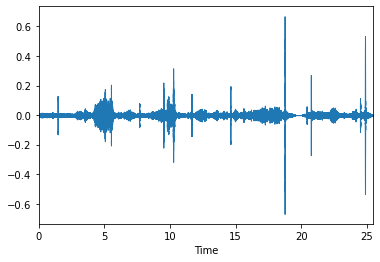

In [10]:
display.waveplot(y, sr=SR)

In [11]:
# model_config = {
#     "sample_rate": 32000,
#     "window_size": 1024,
#     "hop_size": 256,
#     "mel_bins": 128,
#     "fmin": 50,
#     "fmax": 14000,
#     "classes_num": 264
# }

model_config = {
    "sample_rate": 32000,
    "window_size": 1024,
    "hop_size": 320,
    "mel_bins": 64,
    "fmin": 20,
    "fmax": 16000,
    "classes_num": 264
}

model = PANNsCNN14Att(**model_config)

In `PANNsCNN14Att`, input raw waveform will be converted into log-melspectrogram using `torchlibrosa`'s utilities. I put this functionality in `PANNsCNN14Att.preprocess()` method. Let's check the output.

In [12]:
chunk = torch.from_numpy(y[:SR * 5]).unsqueeze(0)
melspec, _ = model.preprocess(chunk)
melspec.size()

torch.Size([1, 1, 501, 64])

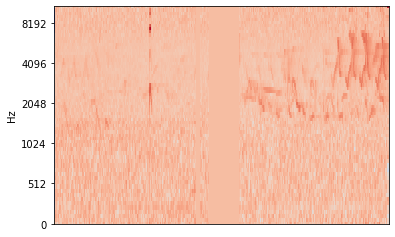

In [13]:
melspec_numpy = melspec.detach().numpy()[0, 0].transpose(1, 0)
display.specshow(melspec_numpy, sr=SR, y_axis="mel");

`PANNsCNN14Att.cnn_feature_extractor()` method will take this as input and output feature map. Let's check the output of the feature extractor.

In [14]:
feature_map = model.cnn_feature_extractor(melspec)
feature_map.size()

torch.Size([1, 2048, 15, 2])

Although it's downsized through several convolution and pooling layers, the size of it's third dimension is 15 and it still contains time information. Each element of this dimension is *segment*. In SED model, we provide prediction for each of this.

Now, let's try to train this model in weakly-supervised manner.

### Dataset

In [15]:
BIRD_CODE = {
    'aldfly': 0, 'ameavo': 1, 'amebit': 2, 'amecro': 3, 'amegfi': 4,
    'amekes': 5, 'amepip': 6, 'amered': 7, 'amerob': 8, 'amewig': 9,
    'amewoo': 10, 'amtspa': 11, 'annhum': 12, 'astfly': 13, 'baisan': 14,
    'baleag': 15, 'balori': 16, 'banswa': 17, 'barswa': 18, 'bawwar': 19,
    'belkin1': 20, 'belspa2': 21, 'bewwre': 22, 'bkbcuc': 23, 'bkbmag1': 24,
    'bkbwar': 25, 'bkcchi': 26, 'bkchum': 27, 'bkhgro': 28, 'bkpwar': 29,
    'bktspa': 30, 'blkpho': 31, 'blugrb1': 32, 'blujay': 33, 'bnhcow': 34,
    'boboli': 35, 'bongul': 36, 'brdowl': 37, 'brebla': 38, 'brespa': 39,
    'brncre': 40, 'brnthr': 41, 'brthum': 42, 'brwhaw': 43, 'btbwar': 44,
    'btnwar': 45, 'btywar': 46, 'buffle': 47, 'buggna': 48, 'buhvir': 49,
    'bulori': 50, 'bushti': 51, 'buwtea': 52, 'buwwar': 53, 'cacwre': 54,
    'calgul': 55, 'calqua': 56, 'camwar': 57, 'cangoo': 58, 'canwar': 59,
    'canwre': 60, 'carwre': 61, 'casfin': 62, 'caster1': 63, 'casvir': 64,
    'cedwax': 65, 'chispa': 66, 'chiswi': 67, 'chswar': 68, 'chukar': 69,
    'clanut': 70, 'cliswa': 71, 'comgol': 72, 'comgra': 73, 'comloo': 74,
    'commer': 75, 'comnig': 76, 'comrav': 77, 'comred': 78, 'comter': 79,
    'comyel': 80, 'coohaw': 81, 'coshum': 82, 'cowscj1': 83, 'daejun': 84,
    'doccor': 85, 'dowwoo': 86, 'dusfly': 87, 'eargre': 88, 'easblu': 89,
    'easkin': 90, 'easmea': 91, 'easpho': 92, 'eastow': 93, 'eawpew': 94,
    'eucdov': 95, 'eursta': 96, 'evegro': 97, 'fiespa': 98, 'fiscro': 99,
    'foxspa': 100, 'gadwal': 101, 'gcrfin': 102, 'gnttow': 103, 'gnwtea': 104,
    'gockin': 105, 'gocspa': 106, 'goleag': 107, 'grbher3': 108, 'grcfly': 109,
    'greegr': 110, 'greroa': 111, 'greyel': 112, 'grhowl': 113, 'grnher': 114,
    'grtgra': 115, 'grycat': 116, 'gryfly': 117, 'haiwoo': 118, 'hamfly': 119,
    'hergul': 120, 'herthr': 121, 'hoomer': 122, 'hoowar': 123, 'horgre': 124,
    'horlar': 125, 'houfin': 126, 'houspa': 127, 'houwre': 128, 'indbun': 129,
    'juntit1': 130, 'killde': 131, 'labwoo': 132, 'larspa': 133, 'lazbun': 134,
    'leabit': 135, 'leafly': 136, 'leasan': 137, 'lecthr': 138, 'lesgol': 139,
    'lesnig': 140, 'lesyel': 141, 'lewwoo': 142, 'linspa': 143, 'lobcur': 144,
    'lobdow': 145, 'logshr': 146, 'lotduc': 147, 'louwat': 148, 'macwar': 149,
    'magwar': 150, 'mallar3': 151, 'marwre': 152, 'merlin': 153, 'moublu': 154,
    'mouchi': 155, 'moudov': 156, 'norcar': 157, 'norfli': 158, 'norhar2': 159,
    'normoc': 160, 'norpar': 161, 'norpin': 162, 'norsho': 163, 'norwat': 164,
    'nrwswa': 165, 'nutwoo': 166, 'olsfly': 167, 'orcwar': 168, 'osprey': 169,
    'ovenbi1': 170, 'palwar': 171, 'pasfly': 172, 'pecsan': 173, 'perfal': 174,
    'phaino': 175, 'pibgre': 176, 'pilwoo': 177, 'pingro': 178, 'pinjay': 179,
    'pinsis': 180, 'pinwar': 181, 'plsvir': 182, 'prawar': 183, 'purfin': 184,
    'pygnut': 185, 'rebmer': 186, 'rebnut': 187, 'rebsap': 188, 'rebwoo': 189,
    'redcro': 190, 'redhea': 191, 'reevir1': 192, 'renpha': 193, 'reshaw': 194,
    'rethaw': 195, 'rewbla': 196, 'ribgul': 197, 'rinduc': 198, 'robgro': 199,
    'rocpig': 200, 'rocwre': 201, 'rthhum': 202, 'ruckin': 203, 'rudduc': 204,
    'rufgro': 205, 'rufhum': 206, 'rusbla': 207, 'sagspa1': 208, 'sagthr': 209,
    'savspa': 210, 'saypho': 211, 'scatan': 212, 'scoori': 213, 'semplo': 214,
    'semsan': 215, 'sheowl': 216, 'shshaw': 217, 'snobun': 218, 'snogoo': 219,
    'solsan': 220, 'sonspa': 221, 'sora': 222, 'sposan': 223, 'spotow': 224,
    'stejay': 225, 'swahaw': 226, 'swaspa': 227, 'swathr': 228, 'treswa': 229,
    'truswa': 230, 'tuftit': 231, 'tunswa': 232, 'veery': 233, 'vesspa': 234,
    'vigswa': 235, 'warvir': 236, 'wesblu': 237, 'wesgre': 238, 'weskin': 239,
    'wesmea': 240, 'wessan': 241, 'westan': 242, 'wewpew': 243, 'whbnut': 244,
    'whcspa': 245, 'whfibi': 246, 'whtspa': 247, 'whtswi': 248, 'wilfly': 249,
    'wilsni1': 250, 'wiltur': 251, 'winwre3': 252, 'wlswar': 253, 'wooduc': 254,
    'wooscj2': 255, 'woothr': 256, 'y00475': 257, 'yebfly': 258, 'yebsap': 259,
    'yehbla': 260, 'yelwar': 261, 'yerwar': 262, 'yetvir': 263
}

INV_BIRD_CODE = {v: k for k, v in BIRD_CODE.items()}

In [16]:
PERIOD = 10

class PANNsDataset(data.Dataset):
    def __init__(
            self,
            file_list: List[List[str]],
            waveform_transforms=None):
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.waveform_transforms = waveform_transforms

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)

        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                start = np.random.randint(len_y - effective_length)
                y = y[start:start + effective_length].astype(np.float32)
            else:
                y = y.astype(np.float32)

        labels = np.zeros(len(BIRD_CODE), dtype="f")
        for b_code in ebird_code:
            labels[BIRD_CODE[b_code]] = 1

        return {"waveform": y, "targets": labels}

### Criterion

In [17]:
class PANNsLoss(nn.Module):
    def __init__(self):
        super().__init__()

        self.bce = nn.BCELoss()

    def forward(self, input, target):
        input_ = input["clipwise_output"]
        input_ = torch.where(torch.isnan(input_),
                     torch.zeros_like(input_),
                     input_)
        input_ = torch.where(torch.isinf(input_),
                             torch.zeros_like(input_),
                             input_)
        target = target.float()

        input_ = torch.clamp(input_, 0.0, 1.0)

        return self.bce(input_, target)

### Callbacks

In [18]:
class F1Callback(Callback):
    def __init__(self,
                 input_key: str = "targets",
                 output_key: str = "logits",
                 model_output_key: str = "clipwise_output",
                 prefix: str = "f1"):
        super().__init__(CallbackOrder.Metric)

        self.input_key = input_key
        self.output_key = output_key
        self.model_output_key = model_output_key
        self.prefix = prefix

    def on_loader_start(self, state: State):
        self.prediction: List[np.ndarray] = []
        self.target: List[np.ndarray] = []

    def on_batch_end(self, state: State):
        targ = state.input[self.input_key].detach().cpu().numpy()
        out = state.output[self.output_key]

        clipwise_output = out[self.model_output_key].detach().cpu().numpy()

        self.prediction.append(clipwise_output)
        self.target.append(targ)

        y_pred = clipwise_output.argmax(axis=1)
        y_true = targ.argmax(axis=1)

        score = f1_score(y_true, y_pred, average="macro")
        state.batch_metrics[self.prefix] = score

    def on_loader_end(self, state: State):
        y_pred = np.concatenate(self.prediction, axis=0).argmax(axis=1)
        y_true = np.concatenate(self.target, axis=0).argmax(axis=1)
        score = f1_score(y_true, y_pred, average="macro")
        state.loader_metrics[self.prefix] = score
        if state.is_valid_loader:
            state.epoch_metrics[state.valid_loader + "_epoch_" +
                                self.prefix] = score
        else:
            state.epoch_metrics["train_epoch_" + self.prefix] = score


class mAPCallback(Callback):
    def __init__(self,
                 input_key: str = "targets",
                 output_key: str = "logits",
                 model_output_key: str = "clipwise_output",
                 prefix: str = "mAP"):
        super().__init__(CallbackOrder.Metric)
        self.input_key = input_key
        self.output_key = output_key
        self.model_output_key = model_output_key
        self.prefix = prefix

    def on_loader_start(self, state: State):
        self.prediction: List[np.ndarray] = []
        self.target: List[np.ndarray] = []

    def on_batch_end(self, state: State):
        targ = state.input[self.input_key].detach().cpu().numpy()
        out = state.output[self.output_key]

        clipwise_output = out[self.model_output_key].detach().cpu().numpy()

        self.prediction.append(clipwise_output)
        self.target.append(targ)

        score = average_precision_score(targ, clipwise_output, average=None)
        score = np.nan_to_num(score).mean()
        state.batch_metrics[self.prefix] = score

    def on_loader_end(self, state: State):
        y_pred = np.concatenate(self.prediction, axis=0)
        y_true = np.concatenate(self.target, axis=0)
        score = average_precision_score(y_true, y_pred, average=None)
        score = np.nan_to_num(score).mean()
        state.loader_metrics[self.prefix] = score
        if state.is_valid_loader:
            state.epoch_metrics[state.valid_loader + "_epoch_" +
                                self.prefix] = score
        else:
            state.epoch_metrics["train_epoch_" + self.prefix] = score

### Train

Some code are taken from https://www.kaggle.com/ttahara/training-birdsong-baseline-resnest50-fast .
Thanks @ttahara!

In [19]:
tmp_list = []
for audio_d in TRAIN_RESAMPLED_AUDIO_DIRS:
    if not audio_d.exists():
        continue
    for ebird_d in audio_d.iterdir():
        if ebird_d.is_file():
            continue
        for wav_f in ebird_d.iterdir():
            tmp_list.append([ebird_d.name, wav_f.name, wav_f.as_posix()])
            
train_wav_path_exist = pd.DataFrame(
    tmp_list, columns=["ebird_code", "resampled_filename", "file_path"])

del tmp_list

train_all = pd.merge(
    train, train_wav_path_exist, on=["ebird_code", "resampled_filename"], how="inner")

print(train.shape)
print(train_wav_path_exist.shape)
print(train_all.shape)

(21375, 38)
(21375, 3)
(21375, 39)


In [20]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_all["fold"] = -1
for fold_id, (train_index, val_index) in enumerate(skf.split(train_all, train_all["ebird_code"])):
    train_all.iloc[val_index, -1] = fold_id
    
# # check the propotion
fold_proportion = pd.pivot_table(train_all, index="ebird_code", columns="fold", values="xc_id", aggfunc=len)
print(fold_proportion.shape)

(264, 5)


In [21]:
code_map =dict(zip(train_all['primary_label'].tolist(),train_all['ebird_code'].tolist()))
len(code_map)

264

In [22]:
train_all['sec_code'] = train_all.secondary_labels.apply(lambda x : [code_map[i] for i in eval(x)  if i in code_map.keys()])
train_all[train_all.sec_code.apply(len)>0].shape

(7012, 41)

In [23]:
train_all["final_bird"] = train_all.apply(lambda x : [x['ebird_code']] + x['sec_code'] ,axis=1 )
train_all[['ebird_code','final_bird','sec_code']]


,ebird_code,final_bird,sec_code
0,aldfly,"[aldfly, leafly, grycat, fiespa]","[leafly, grycat, fiespa]"
1,aldfly,[aldfly],[]
2,aldfly,[aldfly],[]
3,aldfly,"[aldfly, grycat, cedwax]","[grycat, cedwax]"
4,aldfly,[aldfly],[]
...,...,...,...
21370,yetvir,"[yetvir, dowwoo, buggna, norpar, norcar, reshaw]","[dowwoo, buggna, norpar, norcar, reshaw]"
21371,yetvir,"[yetvir, reevir1, buggna]","[reevir1, buggna]"
21372,yetvir,[yetvir],[]
21373,yetvir,"[yetvir, norcar]",[norcar]


In [24]:
use_fold = 3
train_file_list = train_all.query("fold != @use_fold")[["file_path", "final_bird"]].values.tolist()
val_file_list = train_all.query("fold == @use_fold")[["file_path", "final_bird"]].values.tolist()

print("[fold {}] train: {}, val: {}".format(use_fold, len(train_file_list), len(val_file_list)))

[fold 3] train: 17100, val: 4275


In [25]:
device = torch.device("cuda:0")

# loaders
loaders = {
    "train": data.DataLoader(PANNsDataset(train_file_list, None), 
                             batch_size=40, 
                             shuffle=True, 
                             num_workers=2, 
                             pin_memory=True, 
                             drop_last=True),
    "valid": data.DataLoader(PANNsDataset(val_file_list, None), 
                             batch_size=64, 
                             shuffle=False,
                             num_workers=2,
                             pin_memory=True,
                             drop_last=False)
}

# model
model_config["classes_num"] = 527
model = PANNsCNN14Att(**model_config)
weights = torch.load("../input/pannscnn14-decisionlevelatt-weight/Cnn14_DecisionLevelAtt_mAP0.425.pth")
# Fixed in V3
model.load_state_dict(weights["model"])
model.att_block = AttBlock(2048, 264, activation='sigmoid')
model.att_block.init_weights()
model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Loss
criterion = PANNsLoss().to(device)

# callbacks
callbacks = [
    F1Callback(input_key="targets", output_key="logits", prefix="f1"),
    mAPCallback(input_key="targets", output_key="logits", prefix="mAP"),
    CheckpointCallback(save_n_best=0)
]

In [26]:
model_config

{'sample_rate': 32000,
 'window_size': 1024,
 'hop_size': 320,
 'mel_bins': 64,
 'fmin': 20,
 'fmax': 16000,
 'classes_num': 527}

In [27]:
# warnings.simplefilter("ignore")

# runner = SupervisedRunner(
#     device=device,
#     input_key="waveform",
#     input_target_key="targets")

# runner.train(
#     model=model,
#     criterion=criterion,
#     loaders=loaders,
#     optimizer=optimizer,
#     scheduler=scheduler,
#     num_epochs=50,
#     verbose=True,
#     logdir=f"fold0",
#     callbacks=callbacks,
#     main_metric="epoch_f1",
#     minimize_metric=False)

In [28]:
# torch.save(model,"pan.pth")

In [29]:
# model.load_state_dict(torch.load("pan.pth").state_dict())

Seems it's learning something.

Now I'll show how this model works in the inference phase. I'll use trained model of this which I trained by myself using the data of this competition in my local environment.

Since [several concerns](https://www.kaggle.com/c/birdsong-recognition/discussion/172356) are expressed about over-sharing of top solutions during competition, and since I do respect those people who have worked hard to improve their scores, I would not make trained weight in common and would not share how I trained this model.

## Prediction with SED model

In [30]:
model_config = {
    "sample_rate": 32000,
    "window_size": 1024,
    "hop_size": 320,
    "mel_bins": 64,
    "fmin": 20,
    "fmax": 16000,
    "classes_num": 264
}

weights_path = "../input/pan-model-new/fold1/checkpoints/best.pth"

In [31]:
def get_model(config: dict, weights_path: str):
    model = PANNsCNN14Att(**config)
    checkpoint = torch.load(weights_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    device = torch.device("cuda")
    model.to(device)
    model.eval()
    return model

In [32]:
best_model  = get_model(model_config, "../input/pan-model/pan_model/best.pth")
model_2 = get_model(model_config, "../input/pan-model/pan_model/fold2.pth")
model_4 = get_model(model_config, "../input/pan-model-new/fold4.pth")
model_5 = get_model(model_config, "../input/pan-model/pan_model/fold0.pth")


In [33]:
def prediction_for_clip(test_df: pd.DataFrame,
                        clip: np.ndarray, 
                        model: PANNsCNN14Att,
                        threshold=0.5):
    PERIOD = 10
    audios = []
    y = clip.astype(np.float32)
    len_y = len(y)
    start = 0
    end = PERIOD * SR
    while True:
        y_batch = y[start:end].astype(np.float32)
        if len(y_batch) != PERIOD * SR:
            y_pad = np.zeros(PERIOD * SR, dtype=np.float32)
            y_pad[:len(y_batch)] = y_batch
            audios.append(y_pad)
            break
        start = end
        end += PERIOD * SR
        audios.append(y_batch)
        
    array = np.asarray(audios)
    tensors = torch.from_numpy(array)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    estimated_event_list = []
    global_time = 0.0
    site = test_df["site"].values[0]
    audio_id = test_df["audio_id"].values[0]
    for image in progress_bar(tensors):
        image = image.view(1, image.size(0))
        image = image.to(device)

        with torch.no_grad():
            prediction = model(image)["framewise_output"].detach().cpu().numpy()[0]
            prediction_2 = best_model(image)["framewise_output"].detach().cpu().numpy()[0]
            prediction_3 = model_2(image)["framewise_output"].detach().cpu().numpy()[0]
            prediction_4 = model_4(image)["framewise_output"].detach().cpu().numpy()[0]
            prediction_5 = model_5(image)["framewise_output"].detach().cpu().numpy()[0]
            
            framewise_outputs = (prediction + prediction_2 + prediction_3 +prediction_4 +prediction_5 )/5
            

        thresholded = framewise_outputs >= threshold

        for target_idx in range(thresholded.shape[1]):
            if thresholded[:, target_idx].mean() == 0:
                pass
            else:
                detected = np.argwhere(thresholded[:, target_idx]).reshape(-1)
                head_idx = 0
                tail_idx = 0
                while True:
                    if (tail_idx + 1 == len(detected)) or (
                            detected[tail_idx + 1] - 
                            detected[tail_idx] != 1):
                        onset = 0.01 * detected[
                            head_idx] + global_time
                        offset = 0.01 * detected[
                            tail_idx] + global_time
                        onset_idx = detected[head_idx]
                        offset_idx = detected[tail_idx]
                        max_confidence = framewise_outputs[
                            onset_idx:offset_idx, target_idx].max()
                        mean_confidence = framewise_outputs[
                            onset_idx:offset_idx, target_idx].mean()
                        estimated_event = {
                            "site": site,
                            "audio_id": audio_id,
                            "ebird_code": INV_BIRD_CODE[target_idx],
                            "onset": onset,
                            "offset": offset,
                            "max_confidence": max_confidence,
                            "mean_confidence": mean_confidence
                        }
                        estimated_event_list.append(estimated_event)
                        head_idx = tail_idx + 1
                        tail_idx = tail_idx + 1
                        if head_idx >= len(detected):
                            break
                    else:
                        tail_idx += 1
        global_time += PERIOD
        
    prediction_df = pd.DataFrame(estimated_event_list)
    return prediction_df

In [34]:
def prediction(test_df: pd.DataFrame,
               test_audio: Path,
               model_config: dict,
               weights_path: str,
               threshold=0.5):
    model = get_model(model_config, weights_path)
    unique_audio_id = test_df.audio_id.unique()

    warnings.filterwarnings("ignore")
    prediction_dfs = []
    for audio_id in unique_audio_id:
        with timer(f"Loading {audio_id}"):
            clip, _ = librosa.load(test_audio / (audio_id + ".mp3"),
                                   sr=SR,
                                   mono=True,
                                   res_type="kaiser_fast")
        
        test_df_for_audio_id = test_df.query(
            f"audio_id == '{audio_id}'").reset_index(drop=True)
        with timer(f"Prediction on {audio_id}"):
            prediction_df = prediction_for_clip(test_df_for_audio_id,
                                                clip=clip,
                                                model=model,
                                                threshold=threshold)

        prediction_dfs.append(prediction_df)
    
    prediction_df = pd.concat(prediction_dfs, axis=0, sort=False).reset_index(drop=True)
    return prediction_df

In [35]:
prediction_df = prediction(test_df=test,
                           test_audio=TEST_AUDIO_DIR,
                           model_config=model_config,
                           weights_path=weights_path,
                           threshold=0.5)

[Loading 41e6fe6504a34bf6846938ba78d13df1] start
[Loading 41e6fe6504a34bf6846938ba78d13df1] done in 1.47 s
[Prediction on 41e6fe6504a34bf6846938ba78d13df1] start


[Prediction on 41e6fe6504a34bf6846938ba78d13df1] done in 1.58 s
[Loading cce64fffafed40f2b2f3d3413ec1c4c2] start
[Loading cce64fffafed40f2b2f3d3413ec1c4c2] done in 0.77 s
[Prediction on cce64fffafed40f2b2f3d3413ec1c4c2] start


[Prediction on cce64fffafed40f2b2f3d3413ec1c4c2] done in 0.24 s
[Loading 99af324c881246949408c0b1ae54271f] start
[Loading 99af324c881246949408c0b1ae54271f] done in 0.97 s
[Prediction on 99af324c881246949408c0b1ae54271f] start


[Prediction on 99af324c881246949408c0b1ae54271f] done in 0.27 s
[Loading 6ab74e177aa149468a39ca10beed6222] start
[Loading 6ab74e177aa149468a39ca10beed6222] done in 0.73 s
[Prediction on 6ab74e177aa149468a39ca10beed6222] start


[Prediction on 6ab74e177aa149468a39ca10beed6222] done in 0.24 s
[Loading b2fd3f01e9284293a1e33f9c811a2ed6] start
[Loading b2fd3f01e9284293a1e33f9c811a2ed6] done in 0.78 s
[Prediction on b2fd3f01e9284293a1e33f9c811a2ed6] start


[Prediction on b2fd3f01e9284293a1e33f9c811a2ed6] done in 0.24 s
[Loading de62b37ebba749d2abf29d4a493ea5d4] start
[Loading de62b37ebba749d2abf29d4a493ea5d4] done in 0.44 s
[Prediction on de62b37ebba749d2abf29d4a493ea5d4] start


[Prediction on de62b37ebba749d2abf29d4a493ea5d4] done in 0.07 s
[Loading 8680a8dd845d40f296246dbed0d37394] start
[Loading 8680a8dd845d40f296246dbed0d37394] done in 0.94 s
[Prediction on 8680a8dd845d40f296246dbed0d37394] start


[Prediction on 8680a8dd845d40f296246dbed0d37394] done in 0.30 s
[Loading 940d546e5eb745c9a74bce3f35efa1f9] start
[Loading 940d546e5eb745c9a74bce3f35efa1f9] done in 1.23 s
[Prediction on 940d546e5eb745c9a74bce3f35efa1f9] start


[Prediction on 940d546e5eb745c9a74bce3f35efa1f9] done in 0.47 s
[Loading 07ab324c602e4afab65ddbcc746c31b5] start
[Loading 07ab324c602e4afab65ddbcc746c31b5] done in 0.64 s
[Prediction on 07ab324c602e4afab65ddbcc746c31b5] start


[Prediction on 07ab324c602e4afab65ddbcc746c31b5] done in 0.18 s
[Loading 899616723a32409c996f6f3441646c2a] start
[Loading 899616723a32409c996f6f3441646c2a] done in 0.94 s
[Prediction on 899616723a32409c996f6f3441646c2a] start


[Prediction on 899616723a32409c996f6f3441646c2a] done in 0.36 s
[Loading 9cc5d9646f344f1bbb52640a988fe902] start
[Loading 9cc5d9646f344f1bbb52640a988fe902] done in 4.06 s
[Prediction on 9cc5d9646f344f1bbb52640a988fe902] start


[Prediction on 9cc5d9646f344f1bbb52640a988fe902] done in 1.64 s
[Loading a56e20a518684688a9952add8a9d5213] start
[Loading a56e20a518684688a9952add8a9d5213] done in 0.73 s
[Prediction on a56e20a518684688a9952add8a9d5213] start


[Prediction on a56e20a518684688a9952add8a9d5213] done in 0.24 s
[Loading 96779836288745728306903d54e264dd] start
[Loading 96779836288745728306903d54e264dd] done in 0.55 s
[Prediction on 96779836288745728306903d54e264dd] start


[Prediction on 96779836288745728306903d54e264dd] done in 0.13 s
[Loading f77783ba4c6641bc918b034a18c23e53] start
[Loading f77783ba4c6641bc918b034a18c23e53] done in 0.61 s
[Prediction on f77783ba4c6641bc918b034a18c23e53] start


[Prediction on f77783ba4c6641bc918b034a18c23e53] done in 0.07 s
[Loading 856b194b097441958697c2bcd1f63982] start
[Loading 856b194b097441958697c2bcd1f63982] done in 0.98 s
[Prediction on 856b194b097441958697c2bcd1f63982] start


[Prediction on 856b194b097441958697c2bcd1f63982] done in 0.18 s


In [36]:
prediction_df

,site,audio_id,ebird_code,onset,offset,max_confidence,mean_confidence
0,site_1,41e6fe6504a34bf6846938ba78d13df1,aldfly,0.32,2.55,0.996665,0.899895
1,site_1,41e6fe6504a34bf6846938ba78d13df1,aldfly,6.72,8.63,0.958681,0.843269
2,site_1,41e6fe6504a34bf6846938ba78d13df1,amegfi,3.52,5.75,0.872339,0.788426
3,site_1,41e6fe6504a34bf6846938ba78d13df1,amegfi,8.32,8.63,0.514920,0.514920
4,site_1,41e6fe6504a34bf6846938ba78d13df1,amered,8.64,10.00,0.871997,0.802426
...,...,...,...,...,...,...,...
959,site_3,856b194b097441958697c2bcd1f63982,aldfly,14.16,15.75,0.999923,0.949553
960,site_3,856b194b097441958697c2bcd1f63982,aldfly,17.68,19.59,0.983224,0.818282
961,site_3,856b194b097441958697c2bcd1f63982,aldfly,20.00,24.15,0.994810,0.908292
962,site_3,856b194b097441958697c2bcd1f63982,aldfly,25.44,27.03,0.998066,0.954702


## Postprocess


In [37]:
labels = {}

for audio_id, sub_df in prediction_df.groupby("audio_id"):
    events = sub_df[["ebird_code", "onset", "offset", "max_confidence", "site"]].values
    n_events = len(events)
    removed_event = []
    # Overlap deletion: this part may not be necessary
    # I deleted this part in other model and found there's no difference on the public LB score.
    for i in range(n_events):
        for j in range(n_events):
            if i == j:
                continue
            if i in removed_event:
                continue
            if j in removed_event:
                continue
            
            event_i = events[i]
            event_j = events[j]
            
            if (event_i[1] - event_j[2] >= 0) or (event_j[1] - event_i[2] >= 0):
                pass
            else:
                later_onset = max(event_i[1], event_j[1])
                sooner_onset = min(event_i[1], event_j[1])
                sooner_offset = min(event_i[2], event_j[2])
                later_offset = max(event_i[2], event_j[2])

                intersection = sooner_offset - later_onset
                union = later_offset - sooner_onset
                
                iou = intersection / union
                if iou > 0.4:
                    if event_i[3] > event_j[3]:
                        removed_event.append(j)
                    else:
                        removed_event.append(i)

    site = events[0][4]
    for i in range(n_events):
        if i in removed_event:
            continue
        event = events[i][0]
        onset = events[i][1]
        offset = events[i][2]
        if site in {"site_1", "site_2"}:
            start_section = int((onset // 5) * 5) + 5
            end_section = int((offset // 5) * 5) + 5
            cur_section = start_section

            row_id = f"{site}_{audio_id}_{start_section}"
            if labels.get(row_id) is not None:
                labels[row_id].add(event)
            else:
                labels[row_id] = set()
                labels[row_id].add(event)

            while cur_section != end_section:
                cur_section += 5
                row_id = f"{site}_{audio_id}_{cur_section}"
                if labels.get(row_id) is not None:
                    labels[row_id].add(event)
                else:
                    labels[row_id] = set()
                    labels[row_id].add(event)
        else:
            row_id = f"{site}_{audio_id}"
            if labels.get(row_id) is not None:
                labels[row_id].add(event)
            else:
                labels[row_id] = set()
                labels[row_id].add(event)

In [38]:
for key in labels:
    labels[key] = " ".join(sorted(list(labels[key])))
    
    
row_ids = list(labels.keys())
birds = list(labels.values())
post_processed = pd.DataFrame({
    "row_id": row_ids,
    "birds": birds
})
post_processed.head()

,row_id,birds
0,site_2_07ab324c602e4afab65ddbcc746c31b5_5,aldfly blujay comyel
1,site_2_07ab324c602e4afab65ddbcc746c31b5_10,aldfly linspa
2,site_2_07ab324c602e4afab65ddbcc746c31b5_15,aldfly
3,site_2_07ab324c602e4afab65ddbcc746c31b5_25,aldfly leafly
4,site_1_41e6fe6504a34bf6846938ba78d13df1_5,aldfly balori comyel grycat leafly wilfly


In [39]:
all_row_id = test[["row_id"]]
submission = all_row_id.merge(post_processed, on="row_id", how="left")
submission = submission.fillna("nocall")
submission.to_csv("submission.csv", index=False)
submission.head(20)

,row_id,birds
0,site_1_41e6fe6504a34bf6846938ba78d13df1_5,aldfly balori comyel grycat leafly wilfly
1,site_1_41e6fe6504a34bf6846938ba78d13df1_10,aldfly amegfi amered balori fiespa grycat leafly
2,site_1_41e6fe6504a34bf6846938ba78d13df1_15,aldfly amegfi amered moudov norcar sonspa whtspa
3,site_1_41e6fe6504a34bf6846938ba78d13df1_20,aldfly amered bkcchi grycat leafly
4,site_1_41e6fe6504a34bf6846938ba78d13df1_25,aldfly amerob balori fiespa leafly redcro
5,site_1_cce64fffafed40f2b2f3d3413ec1c4c2_5,aldfly rethaw
6,site_1_cce64fffafed40f2b2f3d3413ec1c4c2_10,veery
7,site_1_cce64fffafed40f2b2f3d3413ec1c4c2_15,aldfly osprey
8,site_1_cce64fffafed40f2b2f3d3413ec1c4c2_20,baisan casfin larspa
9,site_1_cce64fffafed40f2b2f3d3413ec1c4c2_25,aldfly larspa


In [40]:
submission.birds.value_counts()

aldfly                         7
comyel houwre reevir1          3
aldfly grycat                  2
nocall                         2
aldfly amered amerob btnwar    2
                              ..
aldfly comyel gnwtea rethaw    1
aldfly bkcchi canwar           1
amerob saypho                  1
aldfly amegfi magwar pinsis    1
amered amerob                  1
Name: birds, Length: 65, dtype: int64

## EOF

In [41]:
submission

,row_id,birds
0,site_1_41e6fe6504a34bf6846938ba78d13df1_5,aldfly balori comyel grycat leafly wilfly
1,site_1_41e6fe6504a34bf6846938ba78d13df1_10,aldfly amegfi amered balori fiespa grycat leafly
2,site_1_41e6fe6504a34bf6846938ba78d13df1_15,aldfly amegfi amered moudov norcar sonspa whtspa
3,site_1_41e6fe6504a34bf6846938ba78d13df1_20,aldfly amered bkcchi grycat leafly
4,site_1_41e6fe6504a34bf6846938ba78d13df1_25,aldfly amerob balori fiespa leafly redcro
...,...,...
71,site_3_9cc5d9646f344f1bbb52640a988fe902,aldfly amecro amegfi amered amerob balori bluj...
72,site_3_a56e20a518684688a9952add8a9d5213,aldfly amered grycat hamfly indbun norwat reev...
73,site_3_96779836288745728306903d54e264dd,aldfly btnwar cedwax hamfly sonspa yebfly
74,site_3_f77783ba4c6641bc918b034a18c23e53,aldfly amegfi magwar pinsis
